In [1]:
# Install required packages (remove / comment out if already installed in your environment)
!pip install -q transformers datasets evaluate accelerate scikit-learn emoji optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 17.6 MB/s eta 0:00:00


In [2]:
# Imports
# ---------------------------
import re
import emoji
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
import evaluate
import optuna
import os

# Ensure deterministic-ish behavior
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [3]:
# 1. Load unsplit dataset (full data)
# ---------------------------
dataset = load_dataset("dair-ai/emotion", split="train")  # 'train' here is the full unsplit set
print("Raw dataset:", dataset)
print("Example record:", dataset[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Raw dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
Example record: {'text': 'i didnt feel humiliated', 'label': 0}


Emotion labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


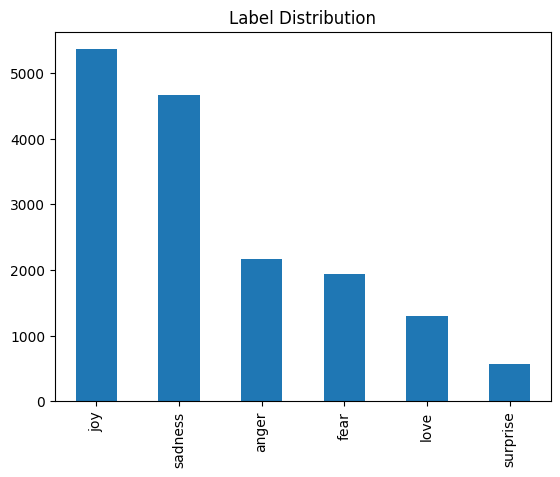

In [4]:
# 2. Inspect labels & distribution
# ---------------------------
labels = dataset.features["label"].names
print("Emotion labels:", labels)
label_counts = pd.Series([labels[l] for l in dataset["label"]]).value_counts()
print(label_counts)
label_counts.plot(kind="bar", title="Label Distribution")
plt.show()

In [5]:
# 3. Preprocessing (keep emojis as :emoji_name:)
#    - replace URLs and user mentions
#    - cap repeated chars
# ---------------------------
URL_RE = re.compile(r"http\S+")
MENTION_RE = re.compile(r"@\w+")
REPEAT_RE = re.compile(r"(.)\1{2,}")  # 3 or more repeats -> cap to 2

def clean_text(s: str):
    s = URL_RE.sub("<URL>", s)
    s = MENTION_RE.sub("<USER>", s)
    s = emoji.demojize(s)  # keep emoji as :smile:
    s = REPEAT_RE.sub(r"\1\1", s)  # cap repeats to two
    s = s.strip()
    return s

# Map cleaning over dataset
dataset = dataset.map(lambda x: {"text": clean_text(x["text"])})
print("Cleaned example:", dataset[0]["text"])


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Cleaned example: i didnt feel humiliated


In [6]:
# 4. Create 80/10/10 splits (stratified)
# ---------------------------
df = dataset.to_pandas()
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=RANDOM_STATE)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=RANDOM_STATE)

train_ds = Dataset.from_pandas(train_df).remove_columns("__index_level_0__")
val_ds = Dataset.from_pandas(val_df).remove_columns("__index_level_0__")
test_ds = Dataset.from_pandas(test_df).remove_columns("__index_level_0__")

print(f"Splits sizes -> train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")

Splits sizes -> train: 12800, val: 1600, test: 1600


In [7]:
# 5. Tokenizer & tokenization
# ---------------------------
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

train_enc = train_ds.map(tokenize_function, batched=True)
val_enc = val_ds.map(tokenize_function, batched=True)
test_enc = test_ds.map(tokenize_function, batched=True)

# Trainer expects "labels" column name (not "label")
train_enc = train_enc.rename_column("label", "labels")
val_enc = val_enc.rename_column("label", "labels")
test_enc = test_enc.rename_column("label", "labels")

# Set format for PyTorch training
columns_to_return = ["input_ids", "attention_mask", "labels"]
train_enc.set_format(type="torch", columns=columns_to_return)
val_enc.set_format(type="torch", columns=columns_to_return)
test_enc.set_format(type="torch", columns=columns_to_return)

num_labels = len(labels)
print("Number of labels:", num_labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Number of labels: 6


In [8]:
# 6. Compute class weights from the training labels
# ---------------------------
# Use the original numeric labels from train_df
class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_labels),
    y=train_df["label"].to_numpy()
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float)
print("Class weights:", class_weights_np)

Class weights: [0.5714796  0.4972805  2.04538191 1.23528276 1.37634409 4.66812546]


In [9]:
# 7. Custom Trainer with weighted loss
# ---------------------------
class CustomTrainer(Trainer):
    """
    Subclass Trainer to provide a custom compute_loss using class weights.
    Works with both model (passed) and model_init (for hyperparameter_search).
    """
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kwargs):
        labels = inputs.get("labels")
        # move class_weights to model device
        device = next(model.parameters()).device
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
        # forward pass
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.get("logits")
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [10]:
# 8. Metrics
# ---------------------------
metric_f1 = evaluate.load("f1")
metric_acc = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels_arr = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=preds, references=labels_arr)["accuracy"]
    f1 = metric_f1.compute(predictions=preds, references=labels_arr, average="macro")["f1"]
    return {"accuracy": acc, "f1_macro": f1}

In [11]:
# 9. TrainingArguments (with logging & evaluation each epoch)
# ---------------------------
output_dir = "./runs/emotion-distilbert"
os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    save_total_limit=2,
    seed=RANDOM_STATE,
    fp16=torch.cuda.is_available(),  # use mixed precision if GPU available
)

# Early stopping callback
early_stopping = EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0001)

# ---------------------------
# 10. Optional: Hyperparameter search with Optuna
#     - Use model_init (fresh model per trial)
# ---------------------------
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def hp_space_optuna(trial):
    # You can tune many hyperparams - keep it small for example
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5)
    }

# Wrap Trainer for search: pass model_init and don't pass model directly.
search_trainer = CustomTrainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

# Run a quick HPO (set n_trials to a small number for quick runs)
RUN_HPO = True
if RUN_HPO:
    print("Starting hyperparameter search (Optuna)...")
    best_run = search_trainer.hyperparameter_search(
        direction="maximize",
        backend="optuna",
        hp_space=hp_space_optuna,
        n_trials=6,            # adjust higher to explore more combinations
        compute_objective=lambda metrics: metrics["eval_f1_macro"]
    )
    print("Best run:", best_run)
    # Update training_args with the best run hyperparams (where applicable)
    best_hyperparams = best_run.hyperparameters
    # convert keys to the TrainingArguments names where needed
    training_args.learning_rate = float(best_hyperparams.get("learning_rate", training_args.learning_rate))
    training_args.per_device_train_batch_size = int(best_hyperparams.get("per_device_train_batch_size", training_args.per_device_train_batch_size))
    training_args.num_train_epochs = int(best_hyperparams.get("num_train_epochs", training_args.num_train_epochs))
    print("Updated training args:", training_args.learning_rate, training_args.per_device_train_batch_size, training_args.num_train_epochs)
else:
    print("Skipping hyperparameter search (RUN_HPO=False).")

/tmp/ipython-input-1406176724.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  search_trainer = CustomTrainer(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-20 06:01:08,428] A new study created in memory with name: no-name-c9a7e64d-4022-4cdc-87ce-47e44162331b


Starting hyperparameter search (Optuna)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: thumula-bhashana (thumula-bhashana-sliit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.533900,0.282010,0.918750,0.891424
2,0.211500,0.348881,0.930625,0.897303
3,0.130900,0.302164,0.929375,0.897467


[I 2025-10-20 06:06:58,599] Trial 0 finished with value: 0.8974668504300998 and parameters: {'learning_rate': 4.9597354200239044e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3}. Best is trial 0 with value: 0.8974668504300998.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█▇
eval/f1_macro,▁██
eval/loss,▁█▃
eval/runtime,▂▁█
eval/samples_per_second,▇█▁
eval/steps_per_second,▇█▁
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/grad_norm,█▃▁
train/learning_rate,█▄▁
+1,...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.767400,0.245730,0.918125,0.892633
2,0.210700,0.251202,0.923125,0.894559
3,0.150500,0.204357,0.926250,0.899011


[I 2025-10-20 06:10:28,608] Trial 1 finished with value: 0.8990113149526401 and parameters: {'learning_rate': 1.439044821699511e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 1 with value: 0.8990113149526401.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅█
eval/f1_macro,▁▃█
eval/loss,▇█▁
eval/runtime,▄▁█
eval/samples_per_second,▅█▁
eval/steps_per_second,▅█▁
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/grad_norm,▂█▁
train/learning_rate,█▄▁
+1,...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.597300,0.228774,0.922500,0.896346
2,0.175800,0.207407,0.930000,0.894039
3,0.121600,0.185869,0.934375,0.908005
4,0.077000,0.226067,0.933125,0.900405


[I 2025-10-20 06:14:29,814] Trial 2 finished with value: 0.9004051557148985 and parameters: {'learning_rate': 4.9679301315638676e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 4}. Best is trial 2 with value: 0.9004051557148985.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅█▇
eval/f1_macro,▂▁█▄
eval/loss,█▅▁█
eval/runtime,▁▆▁█
eval/samples_per_second,█▃█▁
eval/steps_per_second,█▃█▁
train/epoch,▁▁▃▃▆▆███
train/global_step,▁▁▃▃▆▆███
train/grad_norm,█▇▄▁
train/learning_rate,█▆▃▁
+1,...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.537800,0.280872,0.924375,0.898046
2,0.230000,0.334296,0.926250,0.893057
3,0.157600,0.310948,0.930625,0.901834
4,0.108500,0.398325,0.931250,0.898495
5,0.070200,0.430583,0.935000,0.900740


[I 2025-10-20 06:22:20,237] Trial 3 finished with value: 0.9007403562700483 and parameters: {'learning_rate': 2.604904208067749e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5}. Best is trial 3 with value: 0.9007403562700483.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▂▅▆█
eval/f1_macro,▅▁█▅▇
eval/loss,▁▃▂▆█
eval/runtime,▆███▁
eval/samples_per_second,▃▁▁▁█
eval/steps_per_second,▃▁▁▁█
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/grad_norm,█▂▁▁▁
train/learning_rate,█▆▄▃▁
+1,...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.139500,0.421043,0.870000,0.840187
2,0.321000,0.247335,0.913125,0.888252
3,0.218100,0.222199,0.920625,0.896892


[I 2025-10-20 06:25:00,976] Trial 4 finished with value: 0.8968921142622416 and parameters: {'learning_rate': 1.1519766190678676e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 3}. Best is trial 3 with value: 0.9007403562700483.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1_macro,▁▇█
eval/loss,█▂▁
eval/runtime,▁█▄
eval/samples_per_second,█▁▅
eval/steps_per_second,█▁▅
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/grad_norm,▁▇█
train/learning_rate,█▄▁
+1,...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.537600,0.259817,0.928125,0.901127
2,0.193200,0.256968,0.931250,0.900570
3,0.130200,0.240977,0.932500,0.906044
4,0.085700,0.400769,0.930625,0.896171
5,0.046100,0.440168,0.934375,0.899302


[I 2025-10-20 06:30:17,702] Trial 5 finished with value: 0.8993022884121253 and parameters: {'learning_rate': 4.575113571786974e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5}. Best is trial 3 with value: 0.9007403562700483.


Best run: BestRun(run_id='3', objective=0.9007403562700483, hyperparameters={'learning_rate': 2.604904208067749e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5}, run_summary=None)
Updated training args: 2.604904208067749e-05 8 5


In [12]:
# 11. Final trainer (train with best hyperparams or default)
# ---------------------------
trainer = CustomTrainer(
    model_init=model_init,  # ensures fresh model is used (and compatible with load_best_model_at_end)
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

# Train
train_result = trainer.train()
trainer.save_model(os.path.join(output_dir, "best_model_with_weights"))
trainer.state.save_to_json(os.path.join(output_dir, "trainer_state.json"))  # state, including best_model_checkpoint
print("Training completed. Metrics:", train_result.metrics)

/tmp/ipython-input-3954910318.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.537800,0.280872,0.924375,0.898046
2,0.230000,0.334296,0.926250,0.893057
3,0.157600,0.310948,0.930625,0.901834
4,0.108500,0.398325,0.931250,0.898495
5,0.070200,0.430583,0.935000,0.900740


Training completed. Metrics: {'train_runtime': 436.3172, 'train_samples_per_second': 146.682, 'train_steps_per_second': 18.335, 'total_flos': 2119629570048000.0, 'train_loss': 0.2208198356628418, 'epoch': 5.0}


In [13]:
# Save training logs (log_history)
logs_df = pd.DataFrame(trainer.state.log_history)
logs_df.to_csv(os.path.join(output_dir, "training_log_history.csv"), index=False)
print("Saved training log history to", os.path.join(output_dir, "training_log_history.csv"))

Saved training log history to ./runs/emotion-distilbert/training_log_history.csv


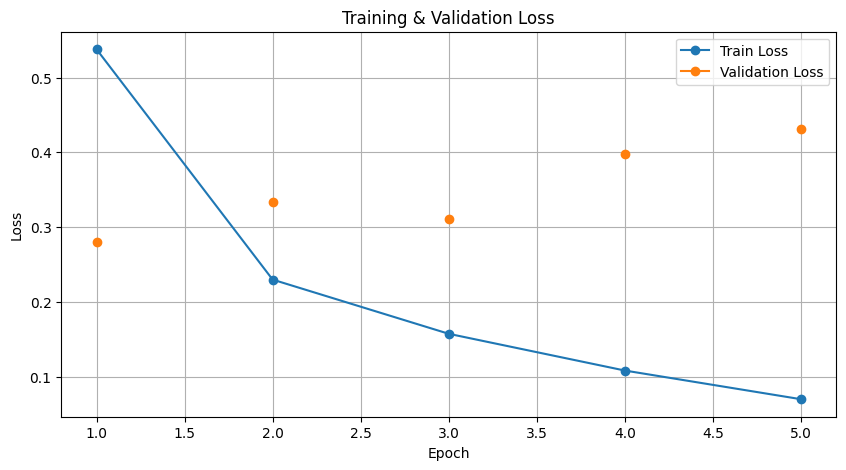

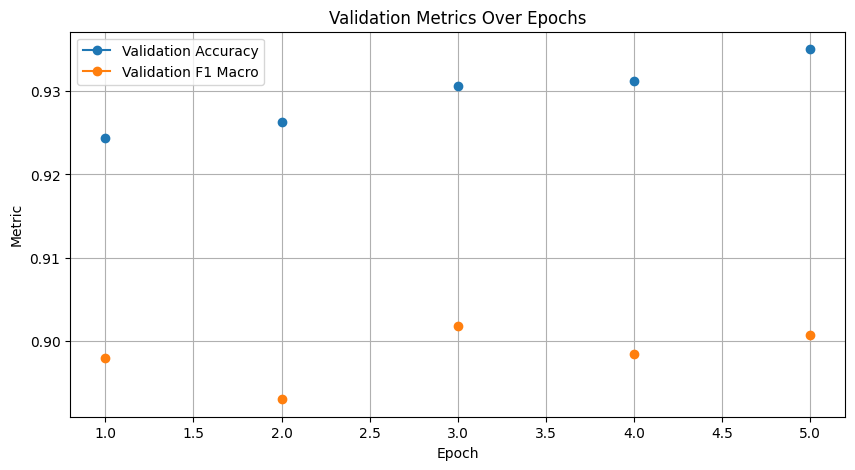

In [14]:
# 12. Plot training/validation curves
# ---------------------------
# Convert log history into DataFrame and aggregate epoch-level metrics
logs = pd.DataFrame(trainer.state.log_history)

# We often have multiple lines per epoch; pick rows where 'epoch' exists
epoch_rows = logs[logs["epoch"].notnull()].copy()
# Make sure numeric epoch index for plotting
epoch_rows["epoch"] = epoch_rows["epoch"].astype(float)

plt.figure(figsize=(10, 5))
if "loss" in logs.columns:
    # Training loss points exist where "loss" is present
    train_loss_rows = logs[logs["loss"].notnull()].groupby("epoch")["loss"].mean().reset_index()
    plt.plot(train_loss_rows["epoch"], train_loss_rows["loss"], label="Train Loss", marker="o")
if "eval_loss" in epoch_rows.columns:
    plt.plot(epoch_rows["epoch"], epoch_rows["eval_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot eval metrics: accuracy and f1_macro if present
plt.figure(figsize=(10, 5))
if "eval_accuracy" in epoch_rows.columns:
    plt.plot(epoch_rows["epoch"], epoch_rows["eval_accuracy"], label="Validation Accuracy", marker="o")
if "eval_f1_macro" in epoch_rows.columns:
    plt.plot(epoch_rows["epoch"], epoch_rows["eval_f1_macro"], label="Validation F1 Macro", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Validation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Running prediction on test set...


Classification report:
              precision    recall  f1-score   support

     sadness      0.978     0.964     0.971       466
         joy      0.983     0.944     0.963       536
        love      0.820     0.946     0.879       130
       anger      0.928     0.958     0.943       216
        fear      0.929     0.871     0.899       194
    surprise      0.775     0.948     0.853        58

    accuracy                          0.943      1600
   macro avg      0.902     0.939     0.918      1600
weighted avg      0.947     0.943     0.944      1600



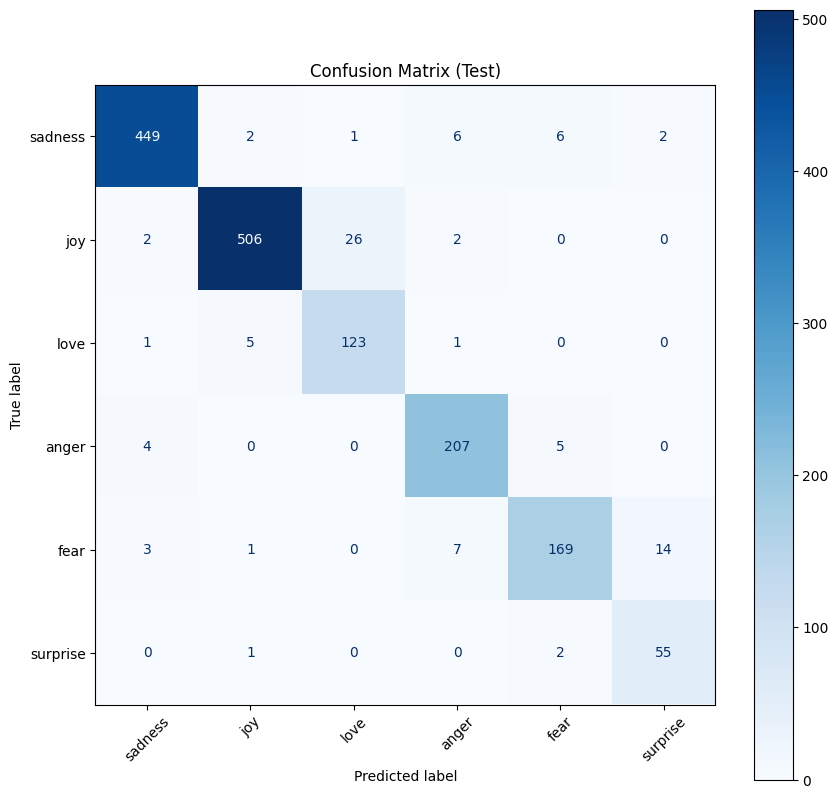

In [15]:
# 13. Evaluate on Test set
# ---------------------------
print("Running prediction on test set...")
pred_output = trainer.predict(test_enc)
y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=-1)

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=3))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test)")
plt.show()

In [16]:
# 14. Inference helper
# ---------------------------
# Load best model into memory (trainer already loaded best model if load_best_model_at_end=True)
model = trainer.model  # already the best model
model.eval()

def predict_emotion(text):
    cleaned = clean_text(text)
    inputs = tokenizer(cleaned, return_tensors="pt", truncation=True, padding=True, max_length=128).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=-1).item()
    return labels[pred]

# Demo
examples = [
    "I’m so happy and excited today!",
    "This is the worst day ever.",
    "I feel nervous about tomorrow.",
    "You make me so angry sometimes.",
    "It's so annoying"
]

for t in examples:
    print(f"{t} -> {predict_emotion(t)}")

I’m so happy and excited today! -> joy
This is the worst day ever. -> sadness
I feel nervous about tomorrow. -> fear
You make me so angry sometimes. -> anger
It's so annoying -> anger


In [17]:
# 15. Save final artifacts & metrics
# ---------------------------
# Already saved model above; save metrics and predictions
pd.DataFrame(pred_output.predictions).to_csv(os.path.join(output_dir, "test_predictions_logits.csv"), index=False)
pd.DataFrame({"y_true": y_true, "y_pred": y_pred}).to_csv(os.path.join(output_dir, "test_pred_vs_true.csv"), index=False)
print("Artifacts saved to", output_dir)

Artifacts saved to ./runs/emotion-distilbert


## Load and use the saved model in a new notebook

To use the trained model in a different notebook, you need to:

1.  Install the required libraries (`transformers`, `datasets`, `emoji`, `torch`, `scikit-learn`).
2.  Define the `clean_text` function (as used during training).
3.  Load the tokenizer and the saved model.
4.  Define the `predict_emotion` function (as used in the training notebook).

In [18]:
# Install required packages if not already installed
!pip install -q transformers datasets evaluate accelerate scikit-learn emoji torch

import re
import emoji
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define the clean_text function (needs to match the one used during training)
URL_RE = re.compile(r"http\S+")
MENTION_RE = re.compile(r"@\w+")
REPEAT_RE = re.compile(r"(.)\1{2,}")

def clean_text(s: str):
    s = URL_RE.sub("<URL>", s)
    s = MENTION_RE.sub("<USER>", s)
    s = emoji.demojize(s)
    s = REPEAT_RE.sub(r"\1\1", s)
    s = s.strip()
    return s

# Define the labels (needs to match the ones used during training)
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Define the path where you saved the model
# Make sure to update this path to where your model is saved
saved_model_path = "./runs/emotion-distilbert/best_model_with_weights"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(saved_model_path)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(saved_model_path)
model.eval()

# Define the predict_emotion function (needs to match the one used during training)
def predict_emotion(text):
    cleaned = clean_text(text)
    inputs = tokenizer(cleaned, return_tensors="pt", truncation=True, padding=True, max_length=128).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=-1).item()
    return labels[pred]

# Example usage:
examples = [
    "I feel amazing today!",
    "This is terrible.",
    "I'm scared of heights.",
    "That made me so mad.",
    "What a pleasant surprise!"
]

for t in examples:
    print(f"{t} -> {predict_emotion(t)}")

I feel amazing today! -> surprise
This is terrible. -> sadness
I'm scared of heights. -> fear
That made me so mad. -> anger
What a pleasant surprise! -> joy


In [19]:
from google.colab import files
import os

# Define the path where you saved the model
saved_model_path = "./runs/emotion-distilbert/best_model_with_weights"

# List all files in the directory
file_list = os.listdir(saved_model_path)

print(f"Downloading files from: {saved_model_path}")

# Download each file
for file_name in file_list:
    file_path = os.path.join(saved_model_path, file_name)
    try:
        files.download(file_path)
        print(f"Downloaded: {file_name}")
    except Exception as e:
        print(f"Could not download {file_name}: {e}")

print("Download process finished.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: vocab.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: config.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: training_args.bin


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: tokenizer.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: tokenizer_config.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: special_tokens_map.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: model.safetensors
Download process finished.


In [ ]:
# List files in the directory where the model was saved
ls -l ./runs/emotion-distilbert/best_model_with_weights

To download these files:

1.  Open the file browser in the left sidebar of Colab (the folder icon).
2.  Navigate to the `./runs/emotion-distilbert/best_model_with_weights` directory.
3.  Right-click on the files and select "Download" or select the directory and download it as a zip archive.